### Logistic Regression

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
import nltk
import seaborn as sns
from time import time
import scikitplot
import scikitplot.plotters as skplt

#### Data

In [2]:
train = pd.read_csv('data.csv')

-------

### Feature Extraction

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
count_vectorizer = CountVectorizer(analyzer="word",
                                   tokenizer=nltk.word_tokenize,
                                   preprocessor= None,
                                   stop_words='english',
                                   max_features=None)  
bag_of_words = count_vectorizer.fit_transform(train['Text'])

In [5]:
bow = bag_of_words.toarray()
bow[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
label = train['Label'].values.ravel()

# One Hot encoding
ohe_label = pd.get_dummies(label).values

# Label Incoding
lbe_label =  LabelEncoder().fit(label).transform(label)

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [9]:
def get_train_test_data(features,target):

    #shuffle the data
    features, target = shuffle(features, target)

    # Split the 'features' and 'targets' data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target, 
                                                    test_size = 0.3,
                                                    random_state = 0)
    # Show the results of the split
    print ("Training set has {} samples.".format(X_train.shape[0]))
    print ("Testing set has {} samples.".format(X_test.shape[0]))
    return X_train, X_test, y_train, y_test

In [10]:
 X_train, X_test, y_train, y_test = get_train_test_data(bow,lbe_label)

Training set has 2181 samples.
Testing set has 936 samples.


--------

### Training

In [11]:
# metrics
from sklearn.metrics import log_loss, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, precision_score,recall_score

In [12]:
def train_predict(learner, X_train, y_train, X_test, y_test, disp_cmat=False): 
    '''
    inputs:
        learner: the learning algorithm to be trained and predicted on
        sample_size: the size of samples (number) to be drawn from training set
        X_train: features training set
        y_train: income training set
        X_test: features testing set
        y_test: income testing set
    '''
    
    results = {}
    c_matrix = {}
   
    
    #  Fit the learner to the training data using slicing with 'sample_size'
    start = time()  # Get start time  -------->
    learner.fit(X_train, y_train)
    end = time()    # Get end time      <--------

    
    
    #  Calculate the training time
    results['train_time'] = end-start
        
        
    #  Get the predictions on the test set,
    #  then get predictions on the training samples
    start = time()  # Get start time    ------->
    predictions_test = learner.predict(X_test)
    predict_prob_test = learner.predict_proba(X_test)
    predictions_train = learner.predict(X_train)
    predict_prob_train = learner.predict_proba(X_train)
    end = time()    # Get end time        <-------
    
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
           
        
    # Compute accuracy on the training samples
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Log loss on the the  training samples
    results['logloss_train'] = log_loss(y_train, predict_prob_train)
        
    # Log loss on the test set
    results['logloss_test'] = log_loss(y_test, predict_prob_test)
    
    # Prepare Confusion Matix
    c_matrix['c_mat'] = confusion_matrix(y_test, predictions_test)
      
        
    #classification report
    #report['classification_report'] = classification_report(y_test, predictions_test)
    
        
    #f1 score
    #results['f1_score'] = f1_score(y_test, predictions_test, average='macro')
    
    
    #results['precission'] = precision_score(y_test, predictions_test, average=None)
    #results['recall'] = recall_score(y_test, predictions_test, average=None)   
    
        
    # Success
    print ("{} trained on {} train data.".format(learner.__class__.__name__,X_train.shape[0]))
        
    if disp_cmat:
        scikitplot.metrics.plot_confusion_matrix(y_test,predictions_test)
        
    # Return the results
    return results, c_matrix 

### Model Look up

In [13]:
from xgboost import XGBClassifier

/Users/dibakarsigdel/anaconda/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier trained on 2181 train data.


({'acc_test': 0.70405982905982911,
  'acc_train': 0.80009170105456218,
  'logloss_test': 0.79239386226384878,
  'logloss_train': 0.62878432801332373,
  'pred_time': 0.4071319103240967,
  'train_time': 19.771661043167114},
 {'c_mat': array([[ 26,   1,   0,  21,  11],
         [  1,   1,   0,  16,   2],
         [  0,   0,   8,  34,   3],
         [  1,   0,   4, 529,  17],
         [ 10,   1,   1, 154,  95]])})

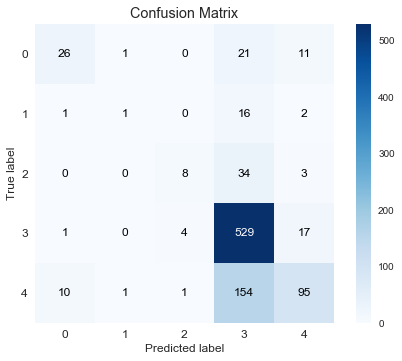

In [15]:
xgb = XGBClassifier()
train_predict( xgb, X_train, y_train, X_test, y_test, disp_cmat=True)

## Overfitting and Under Fitting

In [23]:
 X_train, X_test, y_train, y_test = get_train_test_data(bow,lbe_label)

Training set has 2181 samples.
Testing set has 936 samples.


### Learning Curves

In [20]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [24]:

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    
    train_sizes, train_scores, test_scores = learning_curve(
                               estimator,
                                X, y,
                                cv=cv,
                                n_jobs=n_jobs,
                                train_sizes=train_sizes)
    
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    plt.grid()

    plt.fill_between(train_sizes,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    
    plt.plot(train_sizes,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    
    plt.plot(train_sizes, 
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    

    plt.legend(loc="best")
    return plt


In [ ]:
title = "Learning Curves (XGBClassifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = XGBClassifier()
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

### Validation Curves

In [74]:
from sklearn.model_selection import validation_curve

In [131]:
def plot_validation_curve(estimator, param_range, param_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Parameter C")
    plt.ylabel("Score")
    
    
    
    train_scores, test_scores\
               = validation_curve(estimator,
                                X, y, 
                                cv=cv,
                                n_jobs=n_jobs,
                                param_name = param_name,
                                param_range = param_range)
    
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    
    plt.grid()

    plt.fill_between(param_range,
                     train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std,
                     alpha=0.1,
                     color="r")
    
    plt.fill_between(param_range,
                     test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std,
                     alpha=0.1,
                     color="g")
    
    plt.plot(param_range,
             train_scores_mean,
             'o-',
             color="r",
             label="Training score")
    
    plt.plot(param_range, 
             test_scores_mean,
             'o-',
             color="g",
             label="Cross-validation score")
    

    plt.legend(loc="best")
    return plt

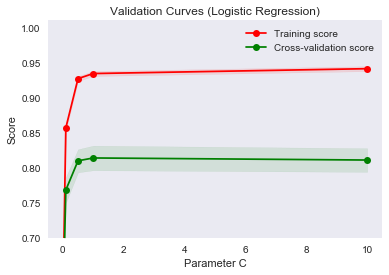

In [132]:
title = "Validation Curves (Logistic Regression)"
param_name = 'learning_rate',
param_range = [0.01,0.05,0.1,0.2,0.4,0.8]
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_validation_curve(estimator, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()